# 4096 Channel 2/1 Oversampled 4 GHz Polyphase Filterbank on the Xilinx RFSoC

This notebook tests the functionality of the OPFB.

## Imports, Definitions, and Instantiating the overlay

In [1]:
from mkidgen3.daccomb import generate as gen_comb
from mkidgen3.pynq import dma_status  ## also activates the drivers
from mkidgen3.testutils import txrx, do_fft, extract_opfb_spec, fir
from mkidgen3.fixedpoint import *
import logging
import numpy as np
import time
import pynq
from pynq import PL, Overlay, DefaultIP, allocate
from fpbinary import FpBinary, OverflowEnum, RoundingEnum
import itertools
import matplotlib.pyplot as plt
from scipy.signal import welch

logging.basicConfig()

n_res = 2048 # number of MKID resonators
n_bin = 4096 # number of PFB channels

# initialize vars for data transfer
n_packets_rcvd, n_packets_sent, pptx, input_buffer = 0, 0, None, None
next_sample_send=0

We've had some issues with unexpected ZCU111 hangs and this was suggesting as a stabilizing measure on the PYNQ forums. This configuration is designed to enable timeouts for PS/PL AXI connnections.

In [2]:
mmio  = pynq.MMIO(0xFD610000 , 64)
mmio.write(0x18, 7) # Return slave errors when timeouts occur
mmio.write(0x20, 0x1020) # Set and enable prescale of 32 which should be about 10 ms
mmio.write(0x10, 0x7) # Enable transactions tracking
mmio.write(0x14, 0x7) # Enable timeouts

Load the overlay and extract the dma core

In [3]:
ol = Overlay('/home/xilinx/overlays/opfb_register_debug/opfb_debug_2.bit')
ol.download()
dma = ol.axi_dma_0
print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")
dma_status(dma)

PL Bitfile: /home/xilinx/overlays/opfb_test.bit
PL Timestamp: 2020/7/29 22:36:54 +469001
Overlay timestamp: 2020/7/29 22:36:54 +469001  Loaded: True
DMA:
 Buffer Length: 262144 bytes
 MM2s
 Idle:False
 MM2S_DMASR (status):0x0
 MM2S_SA (ptr) :0x0
 MM2S_LENGTH (len):0
 S2MM
 Idle:False
 S2MM_DMASR (status):0x0
 S2MM_DA (ptr) :0x0
 S2MM_LENGTH (len):0


## Reading and writing DMA

Prepare some functions to convert numpy data to and from the correct data format.

Keep in mind the cores are based around 256 groups of 8 or 16 samples in parallel. Each sample is either 2 or 4 bytes depending on if they are real or complex. We are sending in a 256 bit stream that will be split into 128 low (I) and 128 high bits (Q), each transaction of which consists of 8 16 bit numbers. The TLAST of the DMA serves as a trigger to the large AXIS FIFO (4096 deep) in the OL that is configured in packet mode to trigger streaming though the opfb cores (data doesn't flow until the DMA write is done). This supports sending up to 16 packets (256 groups of 8 samples) at a time. The adc2opfb core will provide a tlast to the FIR every 512 transactions (1 stream beat).

Since one packet contains 2048 samples it results in 128 new values being fed into each lane packet[0-7::32] is lane0-7 real, packet[0-7 + 8::32] are lane0-7 imag. packet[0-7 + 16::32] is lane8-15 real and packet[0-7 + 24::32] the iamginary. The other 128 values that are sent down the lane are pulled by the adc2fir core from the respective lanes' shift registers. The ADC 2 FIR [sheet](https://docs.google.com/spreadsheets/d/1Aq9HyYat-zHmeC_wIC7wDO6Zweh_Myets_AHY71ldlU/edit#gid=0) in the linked google doc shows the resulting output of a C/RTL simulation of the core when fed with ADC "samples" composed of a ramp of reals. i.e. The first transaction in the beat is 0,1,2,3,4,5,6,7; the second, 8,9,10,11,...15 etc.

The FIR cores (one per lane) are configured with 256 coefficient sets of 8 taps each so that floor(channel/2) gives the coefficient set used. They are not configured to blank the output until the taps are fully loaded. Two stream beats (two packets sent) will fill one tap for all 512 channels (256 channels and their 256 delayed counterparts). So packets 0-13 fill the first 7 taps. Packet 14 and 15 will place data into the last tap. 

The output of the FIRs feeds into the fir2fft core which de-interleaves and buffers the delayed and non-delayed samples in each stream beat. It replays them, non-delayed followed by the delayed samples reordered so that the output ADC sample subseries is convolved with FIR coefficients needed by the FFT. See the FIR 2 FFT sheet in the aformentioned google sheet for the results of the C/RTL simulation on the reorder core.

The reorder core feeds transactions into an 4096 deep (16 packets) AXIS FIFO that is not in packet mode, so it passes things along as soon as the AXI DMA is ready. Since the blocks have latency you can only recieve one less packet than is sent. All recieve operations must be one packet at a time because the TLAST is generated by the reoder core. 

The resulting output stream is similar to the input, though it consists of groups of 16 complex numbers due to the oversampling and is also joins the I and Q values (512 bits, 16x32b, 16 `complex<ap_fixed<-9,25>>`). So the packet needs to be read into a buffer of 8192 uint16s. buffer[::32] is lane0real buffer[1::32] is lane0imag and so forth. 

This overlay is equiped with a System ILA with an 2048 deep capture buffer.
- Slot0: adc2opfb lane0 output
- Slot1: adc2opfb input (istream_data)
- Slot2: fir2fft lane0 input
- Slot3: ssrfft lane0 input

## Prepare the Data

What tones do we want to send?

In [4]:
n_total_packets=280        #How many packets (each packet is enough samples for a single 4096 FFT frame)
n_samples=256*n_total_packets*8  #How many waveform samples do we need to generate
sample_rate=4.096e9

freq=np.array([-300, 100, 151, 1000.5])*1e6  # -2048-2047 MHz
amplitudes = np.ones_like(freq)/n_res
phases=np.zeros_like(freq)

Generate the complex waveform

In [5]:
t = 2 * np.pi * np.arange(n_samples)/sample_rate
comb=np.zeros(n_samples, dtype=np.complex64)
for i in range(freq.size):
    comb += amplitudes[i] * np.exp(1j * (t * freq[i] + phases[i]))

comb=comb.reshape(comb.size//n_res, n_res)
print(f"Comb shape: {comb.shape}. \nTotal Samples: {comb.size}. Memory: {comb.size*8/1024**2:.0f} MB\n"
      f"Max value: {np.abs(comb).max()}.\n"
      f"Expected tone amplitude factor: ~512 * N_TONES_IN_BIN. (4096/8 as FFT scale dfaults to 8 in last 3 stages)\n"
      f"Resulting samples per output bin: {comb.size*2/n_bin}")

Comb shape: (280, 2048). 
Total Samples: 573440. Memory: 4 MB
Max value: 0.001953125.
Expected tone amplitude factor: ~512 * N_TONES_IN_BIN. (4096/8 as FFT scale dfaults to 8 in last 3 stages)
Resulting samples per output bin: 280.0


Plot an FFT of the first full timeseries

In [6]:
if False:
    plt.figure(figsize=(7,4))
    plt.plot(np.fft.fftfreq(comb.size, d=1/sample_rate)/1e9, 
             np.abs(np.fft.fft(comb.ravel(), norm='ortho')))
    plt.xlim(-sample_rate/2e9,sample_rate/2e9);
    plt.xlabel('Freq (GHz)');

## Prepare an output array

In [7]:
packets_out=np.zeros((comb.shape[0], n_bin), dtype=np.complex64)

## Send the data

In [8]:
txrx(dma, comb, 4, packets_out, n_total_packets=280, packet_latency=1, in_per_out=1, bin_out=True,
         txfp=FP16_15, rxfp=(-9,25), wait=True, show=True, tx_post_opfb=False, latency_shift=3*16)

Sent: 4  Pending: 3
Received: 3.
Sent: 8  Pending: 4
Received: 7.
Sent: 12  Pending: 4
Received: 11.
Sent: 16  Pending: 4
Received: 15.
Sent: 20  Pending: 4
Received: 19.
Sent: 24  Pending: 4
Received: 23.
Sent: 28  Pending: 4
Received: 27.
Sent: 32  Pending: 4
Received: 31.
Sent: 36  Pending: 4
Received: 35.
Sent: 40  Pending: 4
Received: 39.
Sent: 44  Pending: 4
Received: 43.
Sent: 48  Pending: 4
Received: 47.
Sent: 52  Pending: 4
Received: 51.
Sent: 56  Pending: 4
Received: 55.
Sent: 60  Pending: 4
Received: 59.
Sent: 64  Pending: 4
Received: 63.
Sent: 68  Pending: 4
Received: 67.
Sent: 72  Pending: 4
Received: 71.
Sent: 76  Pending: 4
Received: 75.
Sent: 80  Pending: 4
Received: 79.
Sent: 84  Pending: 4
Received: 83.
Sent: 88  Pending: 4
Received: 87.
Sent: 92  Pending: 4
Received: 91.
Sent: 96  Pending: 4
Received: 95.
Sent: 100  Pending: 4
Received: 99.
Sent: 104  Pending: 4
Received: 103.
Sent: 108  Pending: 4
Received: 107.
Sent: 112  Pending: 4
Received: 111.
Sent: 116  Pendin

In [9]:
#Optionally save the data to the FPGA
if False:
    np.savez(f"packets_out_opfb.npz", freq=freq, phases=phases, amplitudes=amplitudes, packets_out=packets_out)

## Look at the results

In [10]:
packets_out=np.flip(packets_out, axis=0)

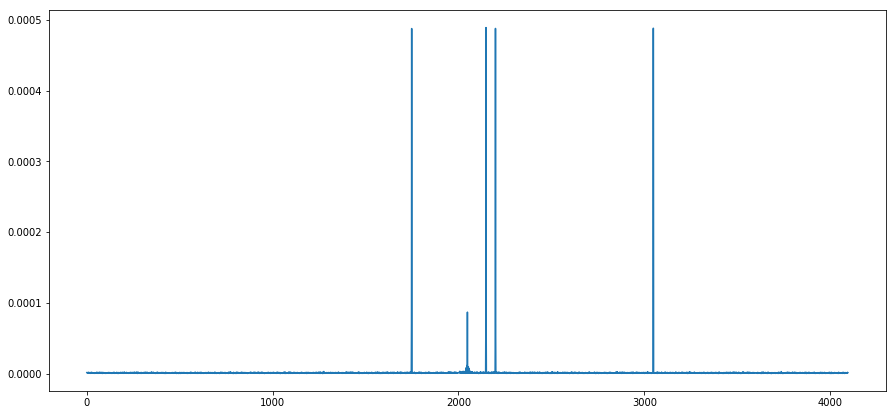

In [17]:
# plot an individual packet
packet_num = 16
plt.figure(figsize=(15,7))
packet = np.fft.fftshift(np.abs(packets_out[packet_num]))
plt.plot(packet)

## Plot the OPFB Spectra

Note pltslc picks out certain FFT frames. We start at 16 with the FPGA data because the first few frames are zeros as the core winds up (check individual packets above). To properly visualize the oversampled spectrum we take the fft of the output time series from each bin. This shows us the frequency content of each bin with spectral resolution 2 MHz/n_packets_received. We stitch the resulting 4096 spectra together, discarding the overlap region, to produce the final, fine spectrum. Not the observed frequency at 0 Hz is the DC offset. This can be mitigated by implementing symmetric rounding to zero at the cost of FPGA resources.

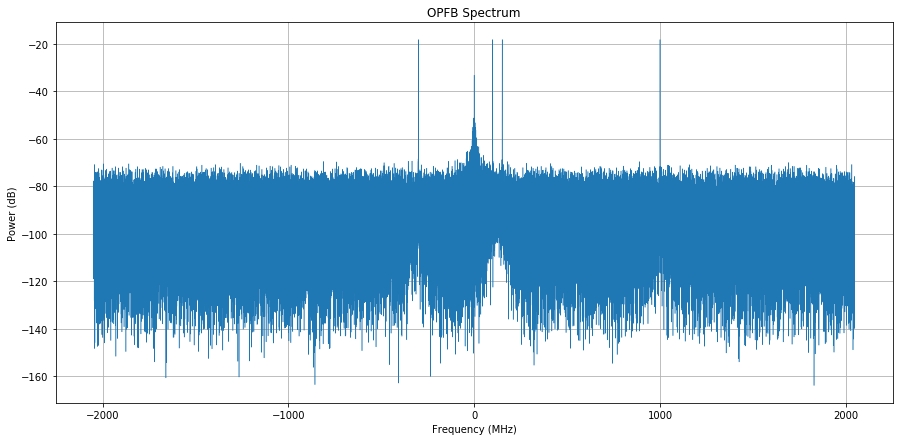

In [12]:
pltslc=slice(16,272)
fpgaplotdata = extract_opfb_spec(do_fft(packets_out, sl=pltslc))
plt.figure(figsize=(15,7))
plt.plot(*fpgaplotdata, label='fpga', linewidth=.5)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dB)')
plt.grid()
plt.title('OPFB Spectrum')
plt.show()

### Lets compute the FIR in python to compare with the FPGA

This will give us some idea if the OPFB is working properly. Note we have only implemented the filters in fixed-point. The FFT is still done in software with floating point precision. Likely, this is the cause of disagreements we see between the FPGA output spectrum and the fixed-point simulation.

In [18]:
# Load the FIR Coefficients
coeffs=np.zeros((16,256,8))  #lane, coeff set, c7-0
for i in range(16):
    with open(f"../filter/lane{i}.coe",'r') as f:
        lines=f.readlines()[1:]
    lines[0]=lines[0].partition('=')[-1]
    coeffs[i]=np.array(list(map(float,''.join(lines).replace(';','').replace('\n','').split(',')))).reshape(256,8)

# Cast coefficients and data to fixed point    
fpcomb16_15=fparray(comb, FP16_15)
fpcoeff16_26=fparray(coeffs, FP16_26)

# Do PFB + FFT
pfb_fp16=do_fixed_point_pfb(fpcomb16_15, fpcoeff16_26)
fp_opfb=np.fft.fft(pfb_fp16.reshape(pfb_fp16.shape[0], n_bin), axis=1) #shifting here causes problems for plotting

In [19]:
#Generate spectra
pltslc=slice(16,272)
fpgaplotdata = extract_opfb_spec(do_fft(packets_out, sl=pltslc))
plotdata_fp16 = extract_opfb_spec(do_fft(pfb_fp16, sl=slice(0,256), do_pfb_fft=True, roll_pfb_fft=0))

/home/xilinx/src/mkidgen3/mkidgen3/testutils.py:255: RuntimeWarning: divide by zero encountered in log10
  data = np.abs(data) if linear else 20 * np.log10(np.abs(data))


In [ ]:
plt.figure(figsize=(15,7))
plt.plot(*plotdata_fp16,label='fp16', linewidth=.8)
plt.plot(*fpgaplotdata*2**8, label='fpga', linewidth=1)
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dB)')
plt.grid()
plt.title('OPFB Spectrum')
plt.show()